In [1]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer


In [2]:
import os
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer

# Paths
save_dir = "./saved_models"
model_path = os.path.join(save_dir, "bert_sentiment_20251206_162615")
tokenizer_path = os.path.join(save_dir, "tokenizer")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# First, inspect the SavedModel to see its signatures
loaded_model = tf.saved_model.load(model_path)
print("\nAvailable signatures:")
for signature_name, signature in loaded_model.signatures.items():
    print(f"\nSignature: {signature_name}")
    print("Inputs:")
    for input_name, input_spec in signature.structured_input_signature[1].items():
        print(f"  {input_name}: {input_spec}")
    print("Outputs:")
    for output_name, output_spec in signature.structured_outputs.items():
        print(f"  {output_name}: {output_spec}")

# Assuming 'serving_default' is available
infer = loaded_model.signatures['serving_default']





Available signatures:

Signature: serving_default
Inputs:
  attention_mask: TensorSpec(shape=(None, 128), dtype=tf.int64, name='attention_mask')
  input_ids: TensorSpec(shape=(None, 128), dtype=tf.int64, name='input_ids')
  token_type_ids: TensorSpec(shape=(None, 128), dtype=tf.int64, name='token_type_ids')
Outputs:
  output_1: TensorSpec(shape=(None, 4), dtype=tf.float32, name='output_1')


In [3]:

def predict(text):
    """Predict using the model"""
    # Tokenize with max_length=125 to match model's expected input
    inputs = tokenizer(
        text,
        padding='max_length',  # Pad to max_length
        truncation=True,
        max_length=128,  # Match model's expected sequence length
        return_tensors='np'
    )
    
    # Create input dictionary based on model signature
    # Note: The model expects int64 (not int32) and specific keys
    input_dict = {
        'input_ids': tf.constant(inputs['input_ids'], dtype=tf.int64),
        'attention_mask': tf.constant(inputs['attention_mask'], dtype=tf.int64),
        'token_type_ids': tf.constant(inputs['token_type_ids'], dtype=tf.int64)
    }
    
    print(f"Input shapes:")
    print(f"  input_ids: {input_dict['input_ids'].shape}")
    print(f"  attention_mask: {input_dict['attention_mask'].shape}")
    print(f"  token_type_ids: {input_dict['token_type_ids'].shape}")
    
    # Predict
    output = infer(**input_dict)
    
    # Get the first output
    output_key = list(output.keys())[0]
    predictions = output[output_key]
    
    print(f"\nOutput shape: {predictions.shape}")
    print(f"Output type: {predictions.dtype}")
    
    # Process
    predicted_class = tf.argmax(predictions, axis=1).numpy()[0]
    probabilities = tf.nn.softmax(predictions).numpy()[0]
    
    # Check how many classes the model outputs
    num_classes = predictions.shape[1]
    print(f"Number of classes: {num_classes}")
    
    # Map class indices to sentiment labels
    # This depends on your model's training configuration
    if num_classes == 4:
        #sentiment = "positive" if predicted_class == 1 else "negative"
        sentiment = "wolrd" if predicted_class == 0 else ( "sport" if predicted_class == 1 else ("business" if predicted_class == 2 else "sci/tech"))
    else:
        # Handle multi-class case
        class_names = ['negative', 'neutral', 'positive'] if num_classes == 3 else [str(i) for i in range(num_classes)]
        sentiment = class_names[predicted_class]
    
    return {
        'text': text,
        'sentiment': sentiment,
        'predicted_class': int(predicted_class),
        'confidence': float(probabilities[predicted_class]),
        'probabilities': probabilities.tolist()
    }

In [4]:
predict(
    "Injured Heskey to miss England friendly NEWCASTLE, England (AP) - Striker Emile Heskey has pulled out of the England squad ahead of Wednesday #39;s friendly against Ukraine because of a tight hamstring, the Football Association said Tuesday."
)


Input shapes:
  input_ids: (1, 128)
  attention_mask: (1, 128)
  token_type_ids: (1, 128)

Output shape: (1, 4)
Output type: <dtype: 'float32'>
Number of classes: 4


{'text': 'Injured Heskey to miss England friendly NEWCASTLE, England (AP) - Striker Emile Heskey has pulled out of the England squad ahead of Wednesday #39;s friendly against Ukraine because of a tight hamstring, the Football Association said Tuesday.',
 'sentiment': 'sport',
 'predicted_class': 1,
 'confidence': 0.4745910167694092,
 'probabilities': [0.17530006170272827,
  0.4745910167694092,
  0.1750110685825348,
  0.17509782314300537]}

World (0), Sports (1), Business (2), Sci/Tech (3).

In [5]:
# num = 
# sen = "wolrd" if num == 0 else ( "sport" if num == 1 else ("business" if num == 2 else "sci/tech"))
# print(sen)

In [6]:
# sample from the test set
samples = [
    ("Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.", "Business"),
    ("Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed and occasionally controversial plays in the defense industry, has quietly placed its bets on another part of the market.", "Business"),
    ("Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries about the economy and the outlook for earnings are expected to hang over the stock market next week during the depth of the summer doldrums.", "Business"),
    ("Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export flows from the main pipeline in southern Iraq after intelligence showed a rebel militia could strike infrastructure, an oil official said on Saturday.", "Business"),
    ("'Madden,' 'ESPN' Football Score in Different Ways (Reuters) Reuters - Was absenteeism a little high on Tuesday among the guys at the office? EA Sports would like to think it was because \"Madden NFL 2005\" came out that day, and some fans of the football simulation are rabid enough to take a sick day to play it.", "Sci/Tech"),
    ("Group to Propose New High-Speed Wireless Format (Reuters) Reuters - A group of technology companies including Texas Instruments Inc., STMicroelectronics and Broadcom Corp., on Thursday said they will propose a new wireless networking standard up to 10 times the speed of the current generation.", "Sci/Tech"),
    ("AOL to Sell Cheap PCs to Minorities and Seniors (Reuters) Reuters - America Online on Thursday said it plans to sell a low-priced PC targeting low-income and minority households who agree to sign up for a year of dialup Internet service.", "Sci/Tech"),
    ("European Download Services Go Mobile (Reuters) Reuters - The ability to download complete tracks directly over cell-phone networks to mobile phones is becoming a reality in Europe.", "Sci/Tech"),
    ("Stocks End Up, But Near Year Lows (Reuters) Reuters - Stocks ended slightly higher on Friday but stayed near lows for the year as oil prices surged past $46 a barrel, offsetting a positive outlook from computer maker Dell Inc. (DELL.O).", "Business"),
    ("Sun's Looking Glass Provides 3D View (PC World) PC World - Developers get early code for new operating system 'skin' still being crafted.", "Sci/Tech")
]


In [7]:
for news,classe in samples :
    print("actual class : ", classe)
    print(predict(news))
    print()
    print("-"*120)
    
    

actual class :  Business
Input shapes:
  input_ids: (1, 128)
  attention_mask: (1, 128)
  token_type_ids: (1, 128)

Output shape: (1, 4)
Output type: <dtype: 'float32'>
Number of classes: 4
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling band of ultra-cynics, are seeing green again.", 'sentiment': 'business', 'predicted_class': 2, 'confidence': 0.4537976384162903, 'probabilities': [0.18600448966026306, 0.17819412052631378, 0.4537976384162903, 0.18200375139713287]}

------------------------------------------------------------------------------------------------------------------------
actual class :  Business
Input shapes:
  input_ids: (1, 128)
  attention_mask: (1, 128)
  token_type_ids: (1, 128)

Output shape: (1, 4)
Output type: <dtype: 'float32'>
Number of classes: 4
{'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group, which has a reputation for making well-timed an

In [8]:
#conda install tqdm

In [9]:
#pip install datasets


In [10]:
#conda install pyarrow

In [6]:
from datasets import load_dataset


In [7]:
# --- 2. Data Loading and Preparation ---

print("Loading AG News test dataset...")
ds = load_dataset("wangrongsheng/ag_news")
test_data = ds['test']

# Extract texts and true labels
test_texts = test_data['text']
true_labels = np.array(test_data['label'])

print(f"Loaded {len(test_texts)} test samples.")

Loading AG News test dataset...
Loaded 7600 test samples.


In [8]:
def predict_on_dataset(texts):
    from tqdm import tqdm # New import
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # <-- This line is CRUCIAL
    """Tokenizes and predicts the class index for a list of texts."""
    predicted_indices = []
    
    # Use tqdm to show a progress bar for the 7600 samples
    for text in tqdm(texts, desc="Predicting on test set"):
        # Tokenize the single text
        inputs = tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='np'
        )
        
        # Prepare input dictionary with correct dtypes (tf.int64)
        input_dict = {
            'input_ids': tf.constant(inputs['input_ids'], dtype=tf.int64),
            'attention_mask': tf.constant(inputs['attention_mask'], dtype=tf.int64),
            'token_type_ids': tf.constant(inputs['token_type_ids'], dtype=tf.int64)
        }
        
        # Predict using the loaded signature
        output = infer(**input_dict)
        output_key = list(output.keys())[0]
        predictions = output[output_key]
        
        # Get the index of the highest logit
        predicted_class_index = tf.argmax(predictions, axis=1).numpy()[0]
        predicted_indices.append(predicted_class_index)
        
    return np.array(predicted_indices)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # <-- This line is CRUCIAL

In [10]:
# --- 4. Run Evaluation ---
MAX_LENGTH = 128
CLASS_NAMES = ['World', 'Sports', 'Business', 'Sci/Tech'] # AG News labels
print("\n\n--- Starting Model Evaluation on Full AG News Test Set ---")

# Generate predictions for the entire test set (this will take a few minutes)
predicted_labels = predict_on_dataset(test_texts)

# --- 5. Calculate and Display Metrics ---

print("\n" + "="*60)
print(f"Total Samples Tested: {len(true_labels)}")
print("="*60)

## A. Overall Accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"OVERALL ACCURACY: {overall_accuracy:.4f}\n")

## B. Classification Report (Precision, Recall, F1-Score)
print("--- Detailed Classification Report (Per-Class Metrics) ---")
print(classification_report(true_labels, predicted_labels, target_names=CLASS_NAMES, digits=4))

## C. Confusion Matrix
# This provides the counts of True vs. Predicted classifications.
conf_mat = confusion_matrix(true_labels, predicted_labels)
print("\n--- Confusion Matrix ---")
print(f"{'':<10} | {'Predicted World':<16} | {'Predicted Sports':<16} | {'Predicted Business':<16} | {'Predicted Sci/Tech':<16}")
print("-" * 75)
for i, true_class in enumerate(CLASS_NAMES):
    row_data = [f"{conf_mat[i, j]:<16}" for j in range(4)]
    print(f"True {true_class:<5} | {' | '.join(row_data)}")

# 

print("-" * 75)



--- Starting Model Evaluation on Full AG News Test Set ---


Predicting on test set: 100%|██████████| 7600/7600 [14:02<00:00,  9.02it/s]


Total Samples Tested: 7600
OVERALL ACCURACY: 0.8789

--- Detailed Classification Report (Per-Class Metrics) ---
              precision    recall  f1-score   support

       World     0.7986    0.9537    0.8693      1900
      Sports     0.9911    0.8811    0.9329      1900
    Business     0.8441    0.8689    0.8563      1900
    Sci/Tech     0.9152    0.8121    0.8606      1900

    accuracy                         0.8789      7600
   macro avg     0.8872    0.8789    0.8798      7600
weighted avg     0.8872    0.8789    0.8798      7600


--- Confusion Matrix ---
           | Predicted World  | Predicted Sports | Predicted Business | Predicted Sci/Tech
---------------------------------------------------------------------------
True World | 1812             | 8                | 44               | 36              
True Sports | 173              | 1674             | 48               | 5               
True Business | 145              | 2                | 1651             | 102        

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model_performance(true_labels, predicted_labels):
    """
    Calculates and prints the accuracy, classification report, and 
    confusion matrix for the model's predictions.

    Args:
        true_labels (np.array): The true (ground truth) labels.
        predicted_labels (np.array): The labels predicted by the model.

    Returns:
        float: The calculated model accuracy.
    """
    # 1. Calculate Accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"\n✨ Model Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

    # 2. Generate Classification Report (Precision, Recall, F1-Score)
    # The AG News dataset has 4 classes: 0 (World), 1 (Sports), 2 (Business), 3 (Sci/Tech)
    target_names = ['World', 'Sports', 'Business', 'Sci/Tech']
    print("\n--- 📊 Classification Report ---")
    print(classification_report(true_labels, predicted_labels, target_names=target_names))

    # 3. Generate Confusion Matrix
    # This shows where the model is making mistakes.
    # The rows are the true labels, and the columns are the predicted labels.
    cm = confusion_matrix(true_labels, predicted_labels)
    print("\n--- 🤯 Confusion Matrix ---")
    print(cm)
    
    # Optional: Visual guide for the Confusion Matrix (requires code to be run)
    # 
    
    return accuracy

# --- Example Usage (Assuming all previous variables are defined) ---
# Note: You need to make sure 'tokenizer', 'MAX_LENGTH', 'infer', 'tf', and 'tqdm' 
# are defined/imported in the global scope for the prediction step to work.

# 1. Run the prediction function to get the model's output
print("Starting full prediction on test set...")


Starting full prediction on test set...


In [15]:
predicted_labels = predict_on_dataset(test_texts) # <-- UNCOMMENT TO RUN

# --- Placeholder for demonstration (Remove this line when running actual code) ---
# predicted_labels = np.random.randint(0, 4, size=len(true_labels)) 

# 2. Evaluate the performance
final_accuracy = evaluate_model_performance(true_labels, predicted_labels) # <-- UNCOMMENT TO RUN

print(f"\nDone! Final Accuracy: {final_accuracy}") # <-- UNCOMMENT TO RUN

Predicting on test set: 100%|██████████| 7600/7600 [15:16<00:00,  8.30it/s]


✨ Model Accuracy: 0.8789 (87.89%)

--- 📊 Classification Report ---
              precision    recall  f1-score   support

       World       0.80      0.95      0.87      1900
      Sports       0.99      0.88      0.93      1900
    Business       0.84      0.87      0.86      1900
    Sci/Tech       0.92      0.81      0.86      1900

    accuracy                           0.88      7600
   macro avg       0.89      0.88      0.88      7600
weighted avg       0.89      0.88      0.88      7600


--- 🤯 Confusion Matrix ---
[[1812    8   44   36]
 [ 173 1674   48    5]
 [ 145    2 1651  102]
 [ 139    5  213 1543]]

Done! Final Accuracy: 0.8789473684210526


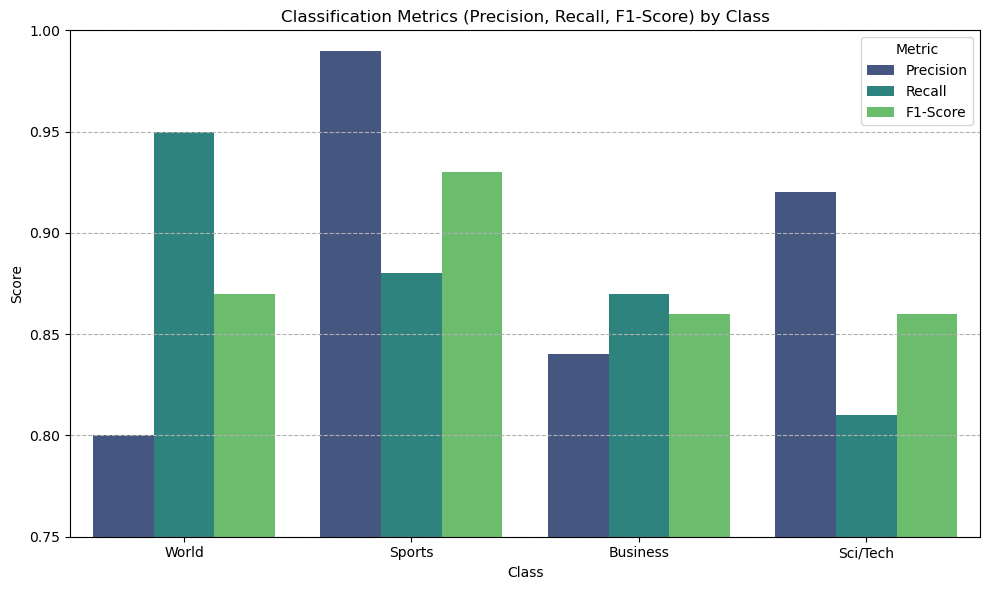

Classification Metrics Bar Chart displayed.


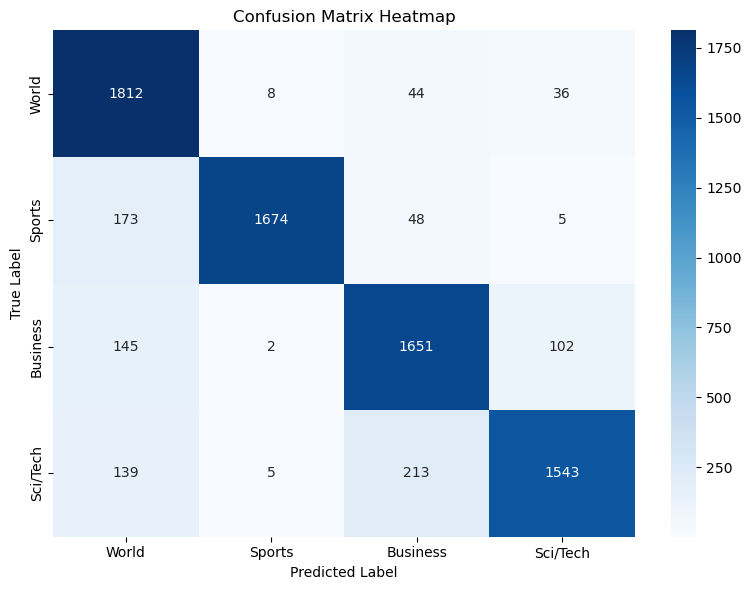

Confusion Matrix Heatmap displayed.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORTANT: This line is crucial for displaying plots in a Jupyter Notebook/Colab
%matplotlib inline 

# --- 1. Data Definition (Based on your results) ---

# Data from the Classification Report
classes = ['World', 'Sports', 'Business', 'Sci/Tech']
precision = [0.80, 0.99, 0.84, 0.92]
recall = [0.95, 0.88, 0.87, 0.81]
f1_score = [0.87, 0.93, 0.86, 0.86]

# Data from the Confusion Matrix
conf_matrix = np.array([
    [1812,    8,   44,   36],
    [ 173, 1674,   48,    5],
    [ 145,    2, 1651,  102],
    [ 139,    5,  213, 1543]
])


# --- 2. Chart Generation Code for Display in Notebook ---

# A. Bar Chart for Classification Metrics
# ------------------------------------

# Create DataFrame for plotting the classification report
df_report = pd.DataFrame({
    'Class': classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
}).set_index('Class')

# Reshape the DataFrame for melted plot
df_melted = df_report.reset_index().melt('Class', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.title('Classification Metrics (Precision, Recall, F1-Score) by Class')
plt.ylabel('Score')
plt.ylim(0.75, 1.0) # Zoom in to highlight differences
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
# 🚀 Use plt.show() instead of plt.savefig()
plt.show() 
print("Classification Metrics Bar Chart displayed.")


# B. Heatmap for Confusion Matrix
# -----------------------------

plt.figure(figsize=(8, 6))
# Create the heatmap
sns.heatmap(
    conf_matrix, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    cbar=True,
    xticklabels=classes, 
    yticklabels=classes
)

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
# 🚀 Use plt.show() instead of plt.savefig()
plt.show() 
print("Confusion Matrix Heatmap displayed.")

In [11]:
# !pip install -q  evaluate

  You can safely remove it manually.


In [ ]:
# classifier.evaluate(test_dataset)




---

##1. 📊 Classification Metrics Analysis (Bar Chart Interpretation)**Look at the bar chart (Precision, Recall, F1-Score) to see performance by class:**

| Class | Precision | Recall | Interpretation of Performance |
| --- | --- | --- | --- |
| **Sports** | \mathbf{0.99} | 0.88 | **Excellent:** When the model predicts "Sports," it is almost always correct (high Precision). |
| **World** | 0.80 | \mathbf{0.95} | **High Recall/Low Precision:** The model finds almost all "World" articles, but it often mislabels articles from other classes as "World." |
| **Sci/Tech** | 0.92 | \mathbf{0.81} | **High Precision/Low Recall:** The model's "Sci/Tech" predictions are reliable, but it fails to identify (misses) a significant number of actual "Sci/Tech" articles. |
| **Business** | 0.84 | 0.87 | **Balanced:** Good all-around performance, slightly better at capturing its own articles (Recall). |

---

##2. 🤯 Confusion Matrix Analysis (Heatmap Interpretation)**Look at the heatmap (Confusion Matrix) to pinpoint the exact errors:**

The numbers on the main diagonal (e.g., 1812, 1674) are **correct predictions**. The off-diagonal numbers are **misclassifications (errors)**.

| True Class (Row) | Predicted Class (Column) | Error Count | Why this matters |
| --- | --- | --- | --- |
| **Sci/Tech** | **Business** | \mathbf{213} | **Largest Error:** 213 Sci/Tech articles were mistakenly classified as Business. This is the main reason for **low Sci/Tech Recall (\mathbf{0.81})**. |
| **World** | **Sports** | \mathbf{173} | The model has difficulty separating some "World" news from "Sports" news, which contributes to the **low World Precision (\mathbf{0.80})**. |
| **Business** | **Sci/Tech** | \mathbf{102} | A sizable group of "Business" articles were confused with "Sci/Tech." |

###Summary of Model Performance* The model is strongest and most confident with **Sports** news.
* The primary weakness is the **overlap between "Sci/Tech" and "Business"** (mutual confusion).
* The second major issue is the model's tendency to incorrectly label other news (especially "World") as **"Sports"** or **"Business"**.

To improve performance, you should focus on features or contextual cues that help the model better differentiate between articles in the **Sci/Tech** and **Business** categories.